# 프로젝트 : 영화리뷰 텍스트 감성분석하기

**두 번째 MLP 프로젝트입니다. CV는 어느 정도 이해가 가는데 자연어 만큼은 확 와닿지가 않습니다.  
그렇다고 MLP를 하기 싫은 것은 아니고 오히려 오기가 생깁니다. CV와 MLP 둘 중에 선택하려면 둘 다 제대로 느껴봐야 하니까 말이죠.  
이번 프로젝트를 작성하고도 MLP가 이해가 안되면 CV로 넘어가는 게 아니라  
오히려 역으로 MLP로 가서 이해가 안가는 부분을 말끔히 해소해볼까도 생각중입니다.**

## 1. 데이터 준비하기
- **데이터 불러오기**
- **데이터 로더 구성하기**

## 2. 데이터 전처리
- **데이터 길이 지정하기**
- **패딩 추가하기**

## 3. 모델 구성하기
- **적정 모델 찾기**

## 4. 모델 학습하기
- **모델 훈련하기**

## 5. Word2Vec 활용하기
- **Embedding 레이어 비교하기**
- **Word2Vec Embedding 적용하고 학습하기**

In [ ]:
import numpy as np
import tensorflow as tf
import os

import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


- - -
### 데이터 준비하기
- **데이터 불러오기**

In [ ]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print(train_data.shape)
print(test_data.shape)

train_data.head()

(150000, 3)
(50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


데이터를 불러와줍니다.

150000개의 학습용 데이터, 50000개의 테스트용 데이터가 있습니다.

`document`은 영화에 대한 평을 문장으로 써놓은 데이터이고, `label`은 그 문장이 영화에 대한 긍정/부정을 표현한 값을 나타냅니다.

- - -
### 1. 데이터 준비하기
- **데이터 로더 구성하기**

모델을 학습하려면 인덱스와 `id`를 제거한 문장과 레이블만을 필요로 하고 문장과 레이블을 나눠야 합니다.

그 과정을 `load_data` 함수를 만들어 저만의 데이터 로더를 만들어주려고 하는데

데이터 로더 함수 내에서 중복, 결측치 확인, 불용어 제거와 함께 인덱스 스트링으로 인코딩까지 해주려고 합니다.

그 전에 함수에 한 번에 적용하려고 하면 복잡하고 어려우니 함수에 넣을 내용을 하나하나 시도해보도록 하죠.

In [ ]:
data = pd.concat([train_data, test_data], axis=0)

data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


`train_data`와 `test_data`를 합친 데이터를 준비해줍니다.

`data`를 변경해도 원래의 `train` 데이터와 `test` 데이터에는 아무런 영향이 없을 것입니다.

In [ ]:
data[data['document'].duplicated()]

,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1
...,...,...,...
49767,4032953,최고,1
49775,632708,괜찮음..,1
49841,8097768,2년이 지나도 잊혀지지 않는 소중한 드라마.,1
49861,9301787,단순 액션물과 마찬가지로 남는 것 없는 팝콘 무비. 역시 짐 캐리 최고의 영화는 트...,0


`duplicated()`을 이용해 중복 먼저 확인해줍니다.

In [ ]:
data.drop_duplicates(['document'], inplace=True)

data[data['document'].duplicated()]

,id,document,label


중복은 학습에 있어 방해가 될 수 있으니 제거해줍니다.

In [ ]:
data.isna().sum()

id          0
document    1
label       0
dtype: int64

결측치도 확인해줍니다.

문장에 결측치가 1개 존재합니다.

In [ ]:
data.loc[data['document'].isna()]

,id,document,label
25857,2172111,NaN,1


`label` 값은 있으면서 문장은 없습니다.

데이터를 준비해오신 분이 결측치를 제거하는 과정도 잊지 말라고 일부러 추가해준 것 같습니다.

In [ ]:
data.dropna(subset=['document'], inplace=True)

data.loc[data['document'].isna()]

,id,document,label


제거해줍니다.

데이터 로더 함수를 만들 때는 결측치가 꼭 `document`에 있을 거란 보장이 없으니

`dropna(how = 'any')`로 `label` 결측치도 함께 대비해줘야 합니다.

In [ ]:
from konlpy.tag import Mecab # 한국어 정보 처리를 위한 라이브러리

tokenizer = Mecab()

data['document'] = data['document'].apply(tokenizer.morphs)

data

,id,document,label
0,9976970,"[아, 더, 빙, ., ., 진짜, 짜증, 나, 네요, 목소리]",0
1,3819312,"[흠, ., .., 포스터, 보고, 초딩, 영화, 줄, ., ..., 오버, 연기,...",1
2,10265843,"[너무, 재, 밓었다그래서보는것을추천한다]",0
3,9045019,"[교도소, 이야기, 구먼, ., ., 솔직히, 재미, 는, 없, 다, ., ., 평...",0
4,6483659,"[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보였, 던, 영화, !, 스파이더맨...",1
...,...,...,...
49995,4608761,"[오랜만, 에, 평점, 로, 긴, 했, 네, ㅋㅋ, 킹왕짱, 쌈, 뽕, 한, 영화,...",1
49996,5308387,"[의지, 박약, 들, 이나, 하, 는, 거, 다, 탈영, 은, 일단, 주인공, 김대...",0
49997,9072549,"[그림, 도, 좋, 고, 완성도, 도, 높, 았, 지만, ., .., 보, 는, 내...",0
49998,5802125,"[절대, 봐서, 는, 안, 될, 영화, ., ., 재미, 도, 없, 고, 기분, 만...",0


문장을 토큰화해줍니다.

일반적으로 공백을 기준으로 토큰화를 하는 것이 아닌

`konlpy` 모듈의 `Mecab`라이브러리를 이용해 형태소를 분석해 토큰화를 진행했습니다.

[KoNLPy](https://konlpy.org/ko/latest/index.html) 는 한국어 정보처리를 위한 패키지라고 볼 수 있습니다.

In [ ]:
stopwords = ['이', '아']

data['document'] = data['document'].apply(lambda x: [word for word in x if word not in stopwords])

data

,id,document,label
0,9976970,"[더, 빙, ., ., 진짜, 짜증, 나, 네요, 목소리]",0
1,3819312,"[흠, ., .., 포스터, 보고, 초딩, 영화, 줄, ., ..., 오버, 연기,...",1
2,10265843,"[너무, 재, 밓었다그래서보는것을추천한다]",0
3,9045019,"[교도소, 이야기, 구먼, ., ., 솔직히, 재미, 는, 없, 다, ., ., 평...",0
4,6483659,"[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보였, 던, 영화, !, 스파이더맨...",1
...,...,...,...
49995,4608761,"[오랜만, 에, 평점, 로, 긴, 했, 네, ㅋㅋ, 킹왕짱, 쌈, 뽕, 한, 영화,...",1
49996,5308387,"[의지, 박약, 들, 이나, 하, 는, 거, 다, 탈영, 은, 일단, 주인공, 김대...",0
49997,9072549,"[그림, 도, 좋, 고, 완성도, 도, 높, 았, 지만, ., .., 보, 는, 내...",0
49998,5802125,"[절대, 봐서, 는, 안, 될, 영화, ., ., 재미, 도, 없, 고, 기분, 만...",0


불용어 제거입니다.

불용어란 문장의 뜻에 관련이 없는 단어를 말합니다.

예를 들어 `장미꽃은 붉다` 에서 `은`을 제외해도 장미꽃이 붉다는 뜻을 해치지 않기 때문에 `은`은 불용어라고 볼 수 있습니다.

지금은 기본적인 틀을 잡으려 하는 것이기 때문에 `이`와 `아`만 제거를 해줬지만 불용어라고 생각하는 단어는 주관적이고 자유로우며

데이터셋마다 달라질 수 있으니 `stopwords` 리스트 안에 원하는 단어를 넣거나 빼면 되겠습니다.

In [ ]:
from collections import Counter

#words = np.concatenate(list(data['document']))
#counter = Counter(words)
#counter = counter.most_common(10000-4)
#vocab = ['', '', '', ''] + [key for key, _ in counter]
#word_to_index = {word:index for index, word in enumerate(vocab)}

데이터에 쓰인 모든 단어들을 사용 빈도 순으로 인덱스화 할 예정입니다.

코드를 차근차근 실행해보겠습니다.

In [ ]:
words = np.concatenate(list(data['document']))

print(len(words))

words

3543615


array(['더', '빙', '.', ..., '또', '왜', '이래'], dtype='<U32')

남아있는 단어를 한 리스트에 전부 담았습니다.

총 354만 개의 단어가 생성됐습니다.

In [ ]:
counter = Counter(words)

print(len(counter))

counter

61548


Counter({'더': 6928,
         '빙': 370,
         '.': 212106,
         '진짜': 11229,
         '짜증': 2004,
         '나': 16967,
         '네요': 11920,
         '목소리': 512,
         '흠': 310,
         '..': 30319,
         '포스터': 745,
         '보고': 696,
         '초딩': 567,
         '영화': 76809,
         '줄': 3806,
         '...': 7014,
         '오버': 189,
         '연기': 9173,
         '조차': 364,
         '가볍': 332,
         '지': 25458,
         '않': 10275,
         '구나': 1074,
         '너무': 14677,
         '재': 2199,
         '밓었다그래서보는것을추천한다': 1,
         '교도소': 23,
         '이야기': 2941,
         '구먼': 51,
         '솔직히': 1428,
         '재미': 5401,
         '는': 89045,
         '없': 21161,
         '다': 73402,
         '평점': 8441,
         '조정': 57,
         '사이몬페그': 2,
         '의': 44789,
         '익살': 16,
         '스런': 300,
         '가': 44425,
         '돋보였': 80,
         '던': 7877,
         '!': 25626,
         '스파이더맨': 79,
         '에서': 10753,
         '늙': 264,
         '어': 116

리스트 안에 있는 값의 카운트를 세서 딕셔너리로 만들어주는 라이브러리입니다.

`'더': 6928`이라는 것은 `더`라는 단어가 6928번 쓰였다는 뜻입니다.

덤으로 중복도 제거되면서 354만 개의 단어가 6만 개로 줄어들었습니다.

In [ ]:
counter = counter.most_common(10000-3)

print(len(counter))

counter

9997


[('.', 212106),
 ('는', 89045),
 ('영화', 76809),
 ('다', 73402),
 ('고', 62828),
 ('하', 59251),
 ('도', 45440),
 ('의', 44789),
 ('가', 44425),
 ('은', 41438),
 ('에', 41177),
 ('을', 39706),
 ('보', 34126),
 ('한', 33634),
 ('..', 30319),
 ('게', 29718),
 (',', 29557),
 ('들', 28808),
 ('!', 25626),
 ('지', 25458),
 ('를', 22864),
 ('있', 22212),
 ('없', 21161),
 ('?', 20458),
 ('좋', 18206),
 ('나', 16967),
 ('었', 16232),
 ('만', 15587),
 ('는데', 15442),
 ('너무', 14677),
 ('봤', 13722),
 ('안', 13511),
 ('적', 13487),
 ('정말', 12985),
 ('로', 12927),
 ('음', 12455),
 ('것', 12385),
 ('으로', 12371),
 ('네요', 11920),
 ('재밌', 11687),
 ('어', 11632),
 ('같', 11475),
 ('점', 11419),
 ('진짜', 11229),
 ('지만', 11160),
 ('했', 10880),
 ('에서', 10753),
 ('기', 10720),
 ('네', 10401),
 ('않', 10275),
 ('거', 10261),
 ('았', 10182),
 ('수', 9999),
 ('되', 9946),
 ('면', 9726),
 ('ㅋㅋ', 9500),
 ('과', 9443),
 ('연기', 9173),
 ('말', 9131),
 ('인', 9060),
 ('잘', 8838),
 ('주', 8809),
 ('평점', 8441),
 ('최고', 8421),
 ('내', 8415),
 ('~', 8370),
 ('이런', 

생성했던 딕셔너리에서 빈도가 많은 순으로 9997개의 단어를 보존했습니다.

    10000에서 3을 뺀 이유는 '<start>', '<unk>', '<pad>'를 추가할 예정이기 때문입니다.

In [ ]:
vocab = ['<PAD>', '<BOS>', '<UNK>'] + [key for key, _ in counter]

vocab

['<PAD>',
 '<BOS>',
 '<UNK>',
 '.',
 '는',
 '영화',
 '다',
 '고',
 '하',
 '도',
 '의',
 '가',
 '은',
 '에',
 '을',
 '보',
 '한',
 '..',
 '게',
 ',',
 '들',
 '!',
 '지',
 '를',
 '있',
 '없',
 '?',
 '좋',
 '나',
 '었',
 '만',
 '는데',
 '너무',
 '봤',
 '안',
 '적',
 '정말',
 '로',
 '음',
 '것',
 '으로',
 '네요',
 '재밌',
 '어',
 '같',
 '점',
 '진짜',
 '지만',
 '했',
 '에서',
 '기',
 '네',
 '않',
 '거',
 '았',
 '수',
 '되',
 '면',
 'ㅋㅋ',
 '과',
 '연기',
 '말',
 '인',
 '잘',
 '주',
 '평점',
 '최고',
 '내',
 '~',
 '이런',
 '던',
 '와',
 '어요',
 '왜',
 '할',
 '겠',
 '해',
 '1',
 '스토리',
 '습니다',
 'ㅋㅋㅋ',
 '...',
 '아니',
 '생각',
 '더',
 '그',
 '드라마',
 '싶',
 '사람',
 '듯',
 '때',
 '감동',
 '배우',
 '함',
 '까지',
 '본',
 '좀',
 '볼',
 '내용',
 '보다',
 '만들',
 '뭐',
 '알',
 '감독',
 '라',
 '그냥',
 '재미',
 '중',
 '시간',
 '지루',
 '재미있',
 '년',
 '였',
 '10',
 '사랑',
 '잼',
 '냐',
 '못',
 '재미없',
 '서',
 '쓰레기',
 '2',
 '라고',
 '번',
 '야',
 '면서',
 '다시',
 '니',
 '나오',
 '작품',
 '이거',
 '하나',
 '해서',
 '줄',
 '개',
 '끝',
 '남',
 '정도',
 '마지막',
 '이건',
 '임',
 '액션',
 '기대',
 '분',
 '라는',
 'ㅋ',
 '3',
 '다는',
 '건',
 '입니다',
 '완전',
 '많',
 '참',
 '

딕셔너리의 순서 그대로 리스트에 단어만 담았습니다.

지금까지의 과정은 단어의 사용 빈도가 많은 순으로 리스트에 담기 위함이였습니다.

In [ ]:
word_to_index = {word:index for index, word in enumerate(vocab)}

word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '.': 3,
 '는': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '도': 9,
 '의': 10,
 '가': 11,
 '은': 12,
 '에': 13,
 '을': 14,
 '보': 15,
 '한': 16,
 '..': 17,
 '게': 18,
 ',': 19,
 '들': 20,
 '!': 21,
 '지': 22,
 '를': 23,
 '있': 24,
 '없': 25,
 '?': 26,
 '좋': 27,
 '나': 28,
 '었': 29,
 '만': 30,
 '는데': 31,
 '너무': 32,
 '봤': 33,
 '안': 34,
 '적': 35,
 '정말': 36,
 '로': 37,
 '음': 38,
 '것': 39,
 '으로': 40,
 '네요': 41,
 '재밌': 42,
 '어': 43,
 '같': 44,
 '점': 45,
 '진짜': 46,
 '지만': 47,
 '했': 48,
 '에서': 49,
 '기': 50,
 '네': 51,
 '않': 52,
 '거': 53,
 '았': 54,
 '수': 55,
 '되': 56,
 '면': 57,
 'ㅋㅋ': 58,
 '과': 59,
 '연기': 60,
 '말': 61,
 '인': 62,
 '잘': 63,
 '주': 64,
 '평점': 65,
 '최고': 66,
 '내': 67,
 '~': 68,
 '이런': 69,
 '던': 70,
 '와': 71,
 '어요': 72,
 '왜': 73,
 '할': 74,
 '겠': 75,
 '해': 76,
 '1': 77,
 '스토리': 78,
 '습니다': 79,
 'ㅋㅋㅋ': 80,
 '...': 81,
 '아니': 82,
 '생각': 83,
 '더': 84,
 '그': 85,
 '드라마': 86,
 '싶': 87,
 '사람': 88,
 '듯': 89,
 '때': 90,
 '감동': 91,
 '배우': 92,
 '함': 93,
 '까지': 94,
 '본': 95,
 '좀':

사용 빈도 순으로 정렬한 단어들에게 다시 인덱스를 부여하며

자주 나오는 단어 순위 딕셔너리를 생성했습니다.

In [ ]:
def wordlist_to_indexlist(wordlist):
        return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

data['document'] = data['document'].apply(wordlist_to_indexlist)

data

,id,document,label
0,9976970,"[1, 84, 936, 3, 3, 46, 236, 28, 41, 751]",0
1,3819312,"[1, 1083, 3, 17, 541, 567, 692, 5, 133, 3, 81,...",1
2,10265843,"[1, 32, 219, 2]",0
3,9045019,"[1, 6700, 169, 3930, 3, 3, 312, 106, 4, 25, 6,...",0
4,6483659,"[1, 2, 10, 8431, 1112, 60, 11, 2846, 70, 5, 21...",1
...,...,...,...
49995,4608761,"[1, 425, 13, 65, 37, 222, 48, 51, 58, 6293, 40...",1
49996,5308387,"[1, 2471, 2, 20, 216, 8, 4, 53, 6, 2, 12, 867,...",0
49997,9072549,"[1, 993, 9, 27, 7, 1350, 9, 267, 54, 47, 3, 17...",0
49998,5802125,"[1, 437, 504, 4, 34, 316, 5, 3, 3, 106, 9, 25,...",0


단어 사전에 부여한 인덱스를 기준으로 단어들을 숫자로 인코딩했습니다.

단어 사전을 만들 때 전체 6만 개의 단어 중 자주 사용된 9997개의 단어까지만 사전에 넣어줬기 때문에

사전에 포함되지 못한 단어가 있으니 그런 경우는 조건문을 통해 `word_to_index['<UNK>']`, 즉 3의 값을 가지게 됩니다.

지금까지 데이터의 중복 제거, 결측치 제거, 토큰화, 불용어 제거, 사전 구성, 문장을 사전 인덱스로 인코딩까지 마쳤습니다.

남은 것은 문장과 레이블을 나눠주는 것 뿐이니 이제 데이터 로더 함수를 만들어보도록 하겠습니다.

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다',
             '어','아','앗','엇','흠','와','.','..','...',',',',,',',,,'] # 불용어 리스트

def load_data(train_data, test_data, num_words=10000): # 사전을 생성할 때 사용될 사용할 단어 수를 인자로 받습니다.
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') # how = 'any': 결측 컬럼이 하나라도 있으면 제거, how = 'all': 모든 컬럼이 결측치면 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train + X_test).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-3)
    vocab = ['<PAD>', '<BOS>', '<UNK>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=10000)

train과 test를 결합한 `data`는 여러가지 전처리의 결과를 확인해볼 용도였습니다.

본격적인 함수는 `train_data`와 `test_data`를 따로 다뤄줍니다.

In [ ]:
for i in range(5):
    print('{} : {}'.format(X_train[i], y_train[i]))

[1, 66, 913, 32, 216, 16, 28, 729] : 0
[1, 521, 546, 670, 3, 114, 1543, 45, 922, 1000, 11, 38, 378] : 1
[1, 20, 199, 2] : 0
[1, 6680, 150, 3908, 292, 87, 13, 4, 50, 3602] : 0
[1, 2, 8412, 1088, 45, 2825, 54, 3, 10, 2859, 35, 1188, 355, 36, 18, 34, 54, 2, 2, 425, 3136, 1812, 4] : 1


앞에서 5개의 문장과 레이블을 가져와봤습니다.

숫자로 되어있어서 맞는 건지는 모르겠습니다. 맞겠죠 뭐.

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '영화',
 4: '다',
 5: '고',
 6: '하',
 7: '을',
 8: '보',
 9: '게',
 10: '!',
 11: '지',
 12: '있',
 13: '없',
 14: '?',
 15: '좋',
 16: '나',
 17: '었',
 18: '만',
 19: '는데',
 20: '너무',
 21: '봤',
 22: '안',
 23: '적',
 24: '정말',
 25: '로',
 26: '음',
 27: '것',
 28: '네요',
 29: '재밌',
 30: '같',
 31: '점',
 32: '진짜',
 33: '지만',
 34: '했',
 35: '에서',
 36: '기',
 37: '네',
 38: '않',
 39: '거',
 40: '았',
 41: '수',
 42: '되',
 43: '면',
 44: 'ㅋㅋ',
 45: '연기',
 46: '말',
 47: '인',
 48: '주',
 49: '최고',
 50: '평점',
 51: '내',
 52: '~',
 53: '이런',
 54: '던',
 55: '어요',
 56: '왜',
 57: '할',
 58: '겠',
 59: '1',
 60: '해',
 61: '스토리',
 62: '습니다',
 63: 'ㅋㅋㅋ',
 64: '아니',
 65: '생각',
 66: '더',
 67: '그',
 68: '드라마',
 69: '싶',
 70: '사람',
 71: '듯',
 72: '때',
 73: '감동',
 74: '배우',
 75: '함',
 76: '까지',
 77: '본',
 78: '볼',
 79: '내용',
 80: '보다',
 81: '만들',
 82: '뭐',
 83: '알',
 84: '감독',
 85: '라',
 86: '그냥',
 87: '재미',
 88: '중',
 89: '시간',
 90: '지루',
 91: '재미있',
 92: '년',
 93: '였',
 94: '10',
 95: '잼'

라고 넘어가면 당연히 안되겠죠.

`items()` 와 간단한 표현식을 이용해 `단어 : 숫자`가 아닌 `숫자 : 단어` 사전도 만들어줍니다.

원리는 x, y = y, x 일 뿐입니다.

In [ ]:
def indexlist_to_wordlist(indexlist):
        return [index_to_word[i] for i in indexlist]
    
for i in range(5):
    print('{} : {}'.format(indexlist_to_wordlist(X_train[i]), y_train[i]))

['<BOS>', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'] : 0
['<BOS>', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'] : 1
['<BOS>', '너무', '재', '<UNK>'] : 0
['<BOS>', '교도소', '이야기', '구먼', '솔직히', '재미', '없', '다', '평점', '조정'] : 0
['<BOS>', '<UNK>', '익살', '스런', '연기', '돋보였', '던', '영화', '!', '스파이더맨', '에서', '늙', '보이', '기', '만', '했', '던', '<UNK>', '<UNK>', '너무나', '이뻐', '보였', '다'] : 1


역으로 인덱스 to 워드 함수도 만들어주고 앞에서 5개의 내용을 다시 읽어봅시다. ~~오차 역전파법이 떠오르네요.~~

- - -
### 2. 데이터 전처리
- **데이터 길이 지정하기**

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

만들어뒀던 단어 to 인덱스, 인덱스 to 단어 딕셔너리를 이용해 문장을 받으면 벡터화해주는 함수입니다.

문장을 학습 전 컴퓨터가 읽을 수 있도록 해주고 학습 후 우리가 읽을 수 있게 관리해주는 용도입니다.

In [ ]:
total_data_text = X_train + X_test
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.410675799507523
문장길이 최대 :  116
문장길이 표준편차 :  11.782777414885688
pad_sequences maxlen :  38
전체 문장의 0.9329934114539339%가 maxlen 설정값 이내에 포함됩니다.


죄송합니다 복붙 좀 했습니다.

문장의 길이 평균 + 문장의 길이 표준편차 값을 기준으로

그보다 길이가 긴 문장은 제외해주겠습니다.

In [ ]:
print(len(X_train))
print(len(X_test))

146182
49157


train은 146182개, test는 49157개의 데이터가 있습니다.

In [ ]:
train = [[document, label] for document, label in zip(get_decoded_sentences(X_train, index_to_word), y_train) \
         if len(document.split()) < maxlen]
test = [[document, label] for document, label in zip(get_decoded_sentences(X_test, index_to_word), y_test) \
        if len(document.split()) < maxlen]

print(len(train))
print(len(test))
train[:5]

136374
45876


[['더 빙 진짜 짜증 나 네요 목소리', 0],
 ['포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나', 1],
 ['너무 재 <UNK>', 0],
 ['교도소 이야기 구먼 솔직히 재미 없 다 평점 조정', 0],
 ['<UNK> 익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다',
  1]]

길이가 38을 넘어가는 문장을 제외해주니 train은 136374개, test는 45876개의 데이터가 남았습니다.

제거를 하면서 레이블과의 순서가 바뀌면 안되니 결합을 해주고 제거했습니다.

    표현식이 이렇게 길어질 줄은 저도 몰랐습니다.

In [ ]:
train = np.array(train).T
test = np.array(test).T

X_train = get_encoded_sentences(list(train[0]), word_to_index)
y_train = np.asarray(train[1]).astype('float32') # 여기서 그냥 array로 했다가 모델 핏에서 오류 한참 찾음

X_test = get_encoded_sentences(list(test[0]), word_to_index)
y_test = np.asarray(test[1]).astype('float32')

print(len(X_train))
print(len(y_train))

136374
136374


결합한 부분을 다시 문장과 레이블로 분리해줍니다.

    처음에 단순히 np.array()로만 했다가 model.fit에서 오류가 나가지고 한참 찾았었습니다..
    형식을 float32로 변환하고 해결했습니다.

- - -
### 2. 데이터 전처리
- **패딩 추가하기**

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(136374, 38)


`<PAD>`를 추가해서 문장들을 모두 38의 길이로 통일해줍니다.

    padding = 'pre'와 'post' 중에 'pre'가 좀 더 좋다고 해서 둘 다 사용해봤습니다.
    결과는 아주 미세하게 'pre'가 좀 더 좋은 결과가 나오는 게 맞았습니다.

- - -
### 3. 모델 구성하기
- **적정 모델 찾기**

In [ ]:
# validation set 30000건 분리
X_val = X_train[:30000]
y_val = y_train[:30000]

# validation set을 제외한 나머지 약 100000건
partial_X_train = X_train[30000:]
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(106374, 38)
(106374,)


앞에서 30000개의 데이터를 밸리데이션 데이터로 분리해줬습니다.

#### *RNN*

In [ ]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 38  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential() # RNN
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 38)          380000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1504      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 381,585
Trainable params: 381,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
208/208 [==============================] - 5s 7ms/step - loss: 0.5010 - accuracy: 0.7865 - val_loss: 0.3633 - val_accuracy: 0.8443
Epoch 2/10
208/208 [==============================] - 1s 6ms/step - loss: 0.3395 - accuracy: 0.8574 - val_loss: 0.3485 - val_accuracy: 0.8493
Epoch 3/10
208/208 [==============================] - 1s 6ms/step - loss: 0.3165 - accuracy: 0.8687 - val_loss: 0.3481 - val_accuracy: 0.8503
Epoch 4/10
208/208 [==============================] - 1s 6ms/step - loss: 0.3037 - accuracy: 0.8746 - val_loss: 0.3506 - val_accuracy: 0.8499
Epoch 5/10
208/208 [==============================] - 1s 5ms/step - loss: 0.2937 - accuracy: 0.8781 - val_loss: 0.3535 - val_accuracy: 0.8489
Epoch 6/10
208/208 [==============================] - 1s 6ms/step - loss: 0.2826 - accuracy: 0.8828 - val_loss: 0.3538 - val_accuracy: 0.8493
Epoch 7/10
208/208 [==============================] - 1s 6ms/step - loss: 0.2706 - accuracy: 0.8877 - val_loss: 0.3593 - val_accuracy: 0.8472
Epoch 

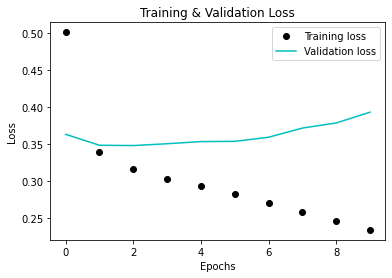

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, 'ko', label='Training loss')
plt.plot(val_loss, 'c', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

`matplotlib`을 이용해 loss의 변화를 시각화해봤습니다.

밸리데이션 loss가 별로 떨어지지가 않네요.

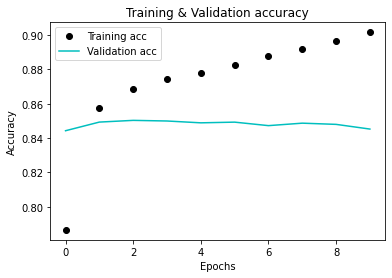

In [ ]:
plt.clf() #그래프 초기화하기

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, 'ko', label='Training acc')
plt.plot(val_acc, 'c', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

정확도의 변화도 시각화해봤습니다.

밸리데이션 정확도도 마찬가지로 크게 상승하지 않았습니다.

In [ ]:
def print_result(results):
    loss = results[0]
    acc = results[1]
    print(f'test_loss : {loss} test_acc : {acc}')

results = model.evaluate(X_test,  y_test, verbose=2)
print_result(results)

1434/1434 - 3s - loss: 0.3945 - accuracy: 0.8429
test_loss : 0.3945137560367584 test_acc : 0.8428590297698975


test 데이터를 예측해서 loss와 정확도를 확인해봤습니다.

좀 더 보기 편하게 출력해주도록 함수를 만들어줬습니다.

test 예측 결과 84%의 정확도가 나왔습니다.

#### *1-D CNN*

In [ ]:
model = tf.keras.Sequential() # 1-D Convolution Neural Network(1-D CNN)
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 38)          380000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3056      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
208/208 [==============================] - 3s 6ms/step - loss: 0.5877 - accuracy: 0.6737 - val_loss: 0.4907 - val_accuracy: 0.7382
Epoch 2/10
208/208 [==============================] - 1s 5ms/step - loss: 0.4615 - accuracy: 0.7633 - val_loss: 0.4799 - val_accuracy: 0.7463
Epoch 3/10
208/208 [==============================] - 1s 5ms/step - loss: 0.4260 - accuracy: 0.7853 - val_loss: 0.4853 - val_accuracy: 0.7471
Epoch 4/10
208/208 [==============================] - 1s 5ms/step - loss: 0.3935 - accuracy: 0.8034 - val_loss: 0.4985 - val_accuracy: 0.7436
Epoch 5/10
208/208 [==============================] - 1s 5ms/step - loss: 0.3563 - accuracy: 0.8236 - val_loss: 0.5269 - val_accuracy: 0.7393
Epoch 6/10
208/208 [==============================] - 1s 5ms/step - loss: 0.3175 - accuracy: 0.8441 - val_loss: 0.5615 - val_accuracy: 0.7377
Epoch 7/10
208/208 [==============================] - 1s 5ms/step - loss: 0.2804 - accuracy: 0.8614 - val_loss: 0.6074 - val_accuracy: 0.7351
Epoch 

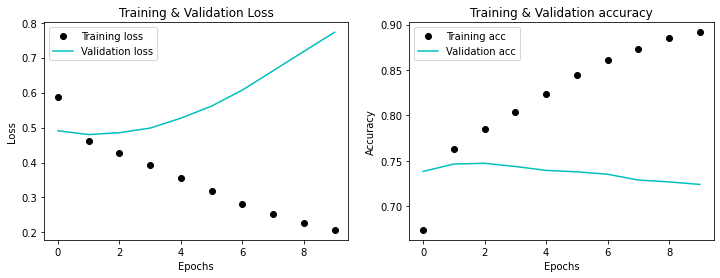

1434/1434 - 2s - loss: 0.7891 - accuracy: 0.7214
test_loss : 0.7890754342079163 test_acc : 0.7214447855949402


In [ ]:
def history_graph(history):
    plt.figure(figsize=(12,4))
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.subplot(1, 2, 1)
    plt.plot(loss, 'ko', label='Training loss')
    plt.plot(val_loss, 'c', label='Validation loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(acc, 'ko', label='Training acc')
    plt.plot(val_acc, 'c', label='Validation acc')
    plt.title('Training & Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
history_graph(history)

results = model.evaluate(X_test,  y_test, verbose=2)
print_result(results)

앞으로 시각화를 자주 사용할 것 같으니 함수로 만들어주겠습니다.

loss가 오히려 역주행하는 모습입니다. 오버피팅이 심하게 일어나는 것 같습니다.

정확도는 72%로 사용하려면 개선을 많이 해야할 것 같습니다.

    그래프가 민트초코와 오레오같네요.

#### *GlobalMaxPooling1D*

In [ ]:
model = tf.keras.Sequential() # GlobalMaxPooling1D()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 38)          380000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 38)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 312       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 380,321
Trainable params: 380,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
208/208 [==============================] - 1s 4ms/step - loss: 0.5740 - accuracy: 0.7283 - val_loss: 0.4101 - val_accuracy: 0.8287
Epoch 2/10
208/208 [==============================] - 1s 4ms/step - loss: 0.3599 - accuracy: 0.8480 - val_loss: 0.3500 - val_accuracy: 0.8471
Epoch 3/10
208/208 [==============================] - 1s 3ms/step - loss: 0.3086 - accuracy: 0.8715 - val_loss: 0.3421 - val_accuracy: 0.8505
Epoch 4/10
208/208 [==============================] - 1s 3ms/step - loss: 0.2775 - accuracy: 0.8869 - val_loss: 0.3449 - val_accuracy: 0.8513
Epoch 5/10
208/208 [==============================] - 1s 3ms/step - loss: 0.2525 - accuracy: 0.8991 - val_loss: 0.3517 - val_accuracy: 0.8517
Epoch 6/10
208/208 [==============================] - 1s 4ms/step - loss: 0.2304 - accuracy: 0.9093 - val_loss: 0.3629 - val_accuracy: 0.8495
Epoch 7/10
208/208 [==============================] - 1s 4ms/step - loss: 0.2098 - accuracy: 0.9198 - val_loss: 0.3762 - val_accuracy: 0.8473
Epoch 

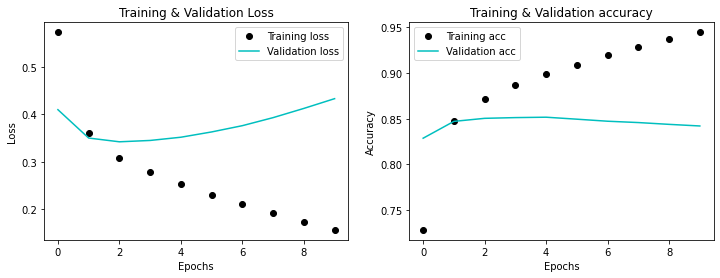

1434/1434 - 2s - loss: 0.4484 - accuracy: 0.8352
test_loss : 0.44839322566986084 test_acc : 0.8352079391479492


In [ ]:
history_graph(history)

results = model.evaluate(X_test,  y_test, verbose=2)
print_result(results)

이번에도 오버피팅이 발생해서 loss가 역주행을 합니다.

정확도는 83%가 나왔습니다.

종합적으로 판단 결과 *RNN*이 가장 학습 결과가 잘 나오는 것 같습니다.

    RNN 너로 정했다.

- - -
### 4. 모델 학습하기
- **모델 훈련하기**

In [ ]:
word_vector_dim = 38

tf.random.set_seed(1337) # 시드 1337 고정

model = tf.keras.Sequential() # RNN
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5)) # 드랍아웃 추가
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 38)          380000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3520      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 383,809
Trainable params: 383,809
Non-trainable params: 0
_________________________________________________________________


정확한 성능 개선을 확인하기 위해 시드를 고정하고 여러 파라미터를 넣어봤습니다.

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', verbose=1, mode=min, patience=5)

모델이 학습을 반복하면서 더 이상 학습에 증진이 없다고 판단되면 스스로 학습을 중단해 오버피팅을 방지하는 기능입니다.

    이강산 퍼실님의 도움을 받았습니다.

Epoch 1/15
104/104 [==============================] - 3s 10ms/step - loss: 0.5607 - accuracy: 0.7327 - val_loss: 0.3829 - val_accuracy: 0.8395
Epoch 2/15
104/104 [==============================] - 1s 7ms/step - loss: 0.3825 - accuracy: 0.8460 - val_loss: 0.3525 - val_accuracy: 0.8485
Epoch 3/15
104/104 [==============================] - 1s 6ms/step - loss: 0.3492 - accuracy: 0.8647 - val_loss: 0.3477 - val_accuracy: 0.8490
Epoch 4/15
104/104 [==============================] - 1s 7ms/step - loss: 0.3333 - accuracy: 0.8719 - val_loss: 0.3480 - val_accuracy: 0.8484
Epoch 5/15
104/104 [==============================] - 1s 6ms/step - loss: 0.3211 - accuracy: 0.8774 - val_loss: 0.3534 - val_accuracy: 0.8459
Epoch 6/15
104/104 [==============================] - 1s 6ms/step - loss: 0.3106 - accuracy: 0.8819 - val_loss: 0.3534 - val_accuracy: 0.8474
Epoch 7/15
104/104 [==============================] - 1s 6ms/step - loss: 0.3011 - accuracy: 0.8849 - val_loss: 0.3579 - val_accuracy: 0.8477
Epoch

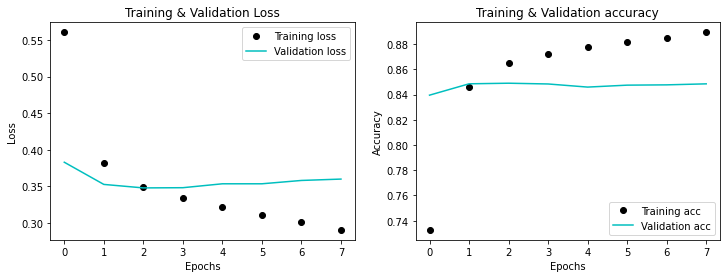

1434/1434 - 3s - loss: 0.3676 - accuracy: 0.8438
test_loss : 0.3676331639289856 test_acc : 0.8437963128089905


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[es]
                    )

history_graph(history)

results = model.evaluate(X_test,  y_test, verbose=2)
print_result(results)

아무리 시도를 해봐도 정확도가 84% 내에서만 머무를 뿐 더 개선되지 않습니다.

- - -
### 5. Word2Vec 활용하기
- **Embedding 레이어 비교하기**

In [ ]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 38)


제가 학습한 Embedding입니다.

In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-3, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 3개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(3, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

제 모델의 임베딩을 `word2vec.txt` 파일에 저장해줬습니다.

제가 만든 모델을 어디다 쓰겠다고 굳이 파일에 저장하느냐면

`Word2VecKeyedVectors`이 파일을 읽으면서 모델을 불러와야 하기 때문입니다.

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['별로']
vector

array([ 0.15554258,  0.18910207, -0.09570634, -0.13713972,  0.142453  ,
        0.00543411,  0.19783935,  0.15240324, -0.19456838,  0.16616353,
        0.17733994, -0.12889384, -0.1872171 ,  0.18727992,  0.11012865,
        0.14051567, -0.15288197,  0.12902959,  0.14467981, -0.10449671,
        0.14490388,  0.14232275, -0.1006313 ,  0.15247735,  0.08308583,
       -0.1985457 , -0.12384224, -0.10363732, -0.13994347,  0.17589225,
        0.08108816,  0.20214982,  0.06863382,  0.12547712,  0.18299703,
       -0.13003786, -0.19457054,  0.15003075], dtype=float32)

`별로`라는 단어의 임베딩을 확인해봤습니다.

모델을 학습하면서 설정했던 `word_vector_dim` 38개의 특성에 대한 관계도를 가지고 있습니다.

In [ ]:
word_vectors.similar_by_word("별로")

[('구림', 0.9751842617988586),
 ('불면증', 0.9714558124542236),
 ('차라리', 0.9640942811965942),
 ('아웃', 0.9640612602233887),
 ('아까워서', 0.9615905284881592),
 ('개뿔', 0.9611119627952576),
 ('오만', 0.9605809450149536),
 ('황당', 0.9603718519210815),
 ('모를까', 0.9596936702728271),
 ('기영화', 0.9593820571899414)]

`similar_by_word`를 이용해 `별로`라는 단어와 유사한 의미를 가지는 단어들을 출력해봤습니다.

의미가 비슷해보이지만 아직은 똑똑해보이지는 않습니다.

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['별로']
vector

array([ 0.10474742, -0.28618118,  0.04916197,  0.02849174, -0.01469383,
        0.13112101, -0.215746  , -0.3781607 ,  0.27315617, -0.01904152,
       -0.17784254, -0.25060332,  0.42781425,  0.03822044, -0.14683788,
       -0.50292856, -0.2855324 , -0.45962378, -0.05805177,  0.02099569,
        0.22074822,  0.04615689, -0.20770957,  0.08722029, -0.35926417,
       -0.08863041, -0.13498157, -0.09754336, -0.06439136,  0.16754867,
       -0.26979974, -0.01031587,  0.25334814, -0.04068481, -0.37561014,
       -0.04937395, -0.25213137,  0.29904142,  0.10240875, -0.29054445,
       -0.05305289, -0.14769654, -0.417107  , -0.07728637, -0.43555835,
        0.10517275, -0.03460033, -0.31088635,  0.0086906 , -0.09822113,
        0.0801606 , -0.09008609, -0.22831158, -0.2709428 , -0.30504772,
        0.26290974,  0.12479951, -0.00415449, -0.01731977, -0.08741904,
       -0.04737182, -0.18641448,  0.10654048, -0.40989098,  0.2771976 ,
       -0.22711767, -0.09633072,  0.04724046, -0.13881786, -0.00

이번에는 준비되어있는 한국어 임베딩 모델을 가져와서 비교해보겠습니다.

총 100개의 차원 수를 가지고 있네요.

In [ ]:
word_vectors.wv.similar_by_word("별로")

[('전혀', 0.6421527862548828),
 ('그다지', 0.6234328746795654),
 ('꽤', 0.6035930514335632),
 ('확실히', 0.5738269090652466),
 ('딱히', 0.5515185594558716),
 ('상당히', 0.542231023311615),
 ('볼일', 0.5412046313285828),
 ('다름', 0.531372606754303),
 ('별', 0.5228564739227295),
 ('확연히', 0.5193501710891724)]

똑같이 `별로`라는 단어와 유사한 의미를 가지는 단어들을 출력해봤습니다.

확실히 제가 학습한 모델보다는 더 똑똑한 것 같습니다.

- - -
### 5. Word2Vec 활용하기
- **Word2Vec Embedding 적용하고 학습하기**

In [ ]:
embedding_matrix = np.random.rand(vocab_size, 100)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(3, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

embedding_matrix

array([[ 0.61199324,  0.74954977,  0.35551349, ...,  0.65937576,
         0.18307407,  0.74919299],
       [ 0.28551529,  0.52886311,  0.38083331, ...,  0.59313763,
         0.96685975,  0.13262458],
       [ 0.81026584,  0.03303883,  0.94579568, ...,  0.35561506,
         0.88329877,  0.04017901],
       ...,
       [-0.17499928,  0.36986989, -0.24962549, ...,  0.11377372,
         0.31240988, -0.03052751],
       [-0.18441887,  4.53077221,  2.07617044, ...,  3.73630214,
        -1.87152076, -1.60325694],
       [ 0.07216076, -0.04893195,  0.01435622, ..., -0.08618334,
         0.03463559,  0.02237131]])

제공하는 임베딩 모델을 적용하고 다시 학습을 진행해보겠습니다.

In [ ]:
from tensorflow.keras.initializers import Constant

tf.random.set_seed(1337)

model = tf.keras.Sequential() # RNN
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 100, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 38, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,018,113
Trainable params: 1,018,113
Non-trainable params: 0
____________________________________________

Epoch 1/20
208/208 [==============================] - 3s 8ms/step - loss: 0.6076 - accuracy: 0.6648 - val_loss: 0.4722 - val_accuracy: 0.7817
Epoch 2/20
208/208 [==============================] - 1s 6ms/step - loss: 0.4619 - accuracy: 0.7918 - val_loss: 0.3933 - val_accuracy: 0.8244
Epoch 3/20
208/208 [==============================] - 1s 6ms/step - loss: 0.4000 - accuracy: 0.8275 - val_loss: 0.3663 - val_accuracy: 0.8382
Epoch 4/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3667 - accuracy: 0.8441 - val_loss: 0.3494 - val_accuracy: 0.8464
Epoch 5/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3423 - accuracy: 0.8572 - val_loss: 0.3438 - val_accuracy: 0.8507
Epoch 6/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3249 - accuracy: 0.8660 - val_loss: 0.3426 - val_accuracy: 0.8514
Epoch 7/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3110 - accuracy: 0.8734 - val_loss: 0.3385 - val_accuracy: 0.8542
Epoch 

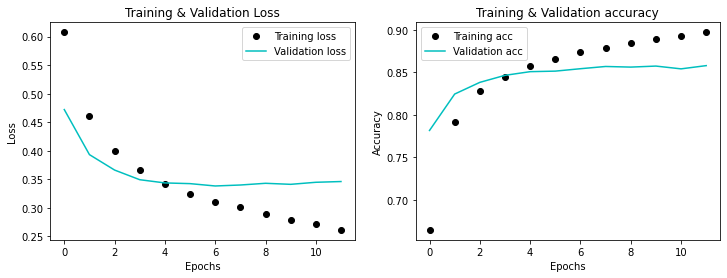

1434/1434 - 3s - loss: 0.3524 - accuracy: 0.8550
test_loss : 0.35238945484161377 test_acc : 0.854956865310669


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[es]
                   )

history_graph(history)

results = model.evaluate(X_test,  y_test, verbose=2)
print_result(results)

84%에서 더 이상 개선이 없던 모델이 85%로 약간 미미하지만 개선이 이뤄졌습니다.

### 마무리하며

이전 MLP 프로젝트에 비해 생각보다 오래 걸렸습니다.

MLP는 데이터 전처리가 힘들다는 말을 들었는데, 확실히 데이터 전처리가 많이 필요하지 않으면서 어렵고, 효과를 보기가 힘든 것 같습니다.

하지만 시간을 오래 투자한 만큼 확실히 MLP와 덤으로 keras 사용법에 대해서 조금은 이해가 된 것 같습니다.

데이터 로더를 예시 답안에서 그대로 복붙해와가지고 많이 애매했습니다.

데이터 로더 구성 자체에는 길이 지정을 비롯해 생략된 전처리 부분을 따로 진행했어야 했는데요.

길이를 지정해서 자르려면 문장과 레이블을 같이 처리해줘야 하고, 데이터를 합칠거면 왜 데이터 로더 함수에서 분리하기 전에 진행하지 않았나

꼭 굳이 나눈걸 다시 합쳤다가 다시 나눠야할까 생각이 들었지만 그냥 함수는 그대로 두고 직접 합치고 버리고 자르는 과정을 진행했습니다.

그러다 레이블을 np.array()로 할당해줬는데 model.fit에서 알 수 없는 오류가 계속 나왔습니다.

오류가 날거면 진작에 날거지 당연히 근처에서 오류가 났을 거라 생각하고 모델 시퀀셜부터 핏까지 한참을 들여다보고

오류 코드를 검색도 해봤지만 저와 같은 사례는 안보이고 번역기로 모두 번역해서 읽은 결과 무언가 형식이 맞지 않다 라고 해서

설마하고 레이블 데이터를 `astype('float')`로 변환하니 몇 시간 만에 겨우 해결됐습니다.

`'<BOS>'` `[1:]` 문제도 있었습니다. 문장 인덱스 변환 함수가 문장으로 변환 시 `[1:]` 슬라이싱을 사용하고,

인덱스로 변환 시 `'<BOS>'`를 추가하는데요. 데이터 로더 함수를 거치면 문장이 인덱스로 토큰화가 진행되어있는 상태라

문장으로 바꾸면 첫 번째 단어가 잘려나가고, 인덱스 상태로 `'<BOS>'`를 넣자니 반복문을 쓰기가 싫었습니다.(습관입니다.)

보기 좋게 해결하는 방법이 무엇이 있을까 고민하다 결국 데이터 로더 함수에 있는 `wordlist_to_indexlist` 함수에서 `'<BOS>'`를 추가해줬습니다.
성능을 확실하게 개선하는 방법이 무엇이 있을까도 고민을 해봤는데요.
실행에 옮기지는 못했지만 '에바', '레알' 등과 같은 비표준어를 표준어로 바꿔주는 전처리를 진행하면 결과가 크게 좋아질 것 같습니다.